#### Import Libraries

Need some more work on it. will be using model.py and utils.py from local for now

In [75]:
"""
from google.colab import drive
drive.mount('/content/drive')

# git repository url
repo_name = "ERA_v2"
git_repo_url = "https://github.com/Gishnumohan/ERA_v2.git"

branch_name = "main"
folder_name = "Assignment10"

#If folder exist remove and then check out main folder to avoid dulicate fatal error
!rm -rf {repo_name} && git clone {git_repo_url}
!cd "{repo_name}" && git checkout {branch_name} && cd "{folder_name}"

# Import user defined modules
from modules.model import CustomResNet as Network
from modules.utils import *
"""


'\nfrom google.colab import drive\ndrive.mount(\'/content/drive\')\n\n# git repository url\nrepo_name = "ERA_v2"\ngit_repo_url = "https://github.com/Gishnumohan/ERA_v2.git"\n\nbranch_name = "main"\nfolder_name = "Assignment10"\n\n#If folder exist remove and then check out main folder to avoid dulicate fatal error\n!rm -rf {repo_name} && git clone {git_repo_url}\n!cd "{repo_name}" && git checkout {branch_name} && cd "{folder_name}"\n\n# Import user defined modules\nfrom modules.model import CustomResNet as Network\nfrom modules.utils import *\n'

In [76]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
!pip install torchinfo
!pip install torch-lr-finder
from torch.optim.lr_scheduler import OneCycleLR
from torch_lr_finder import LRFinder

import matplotlib.pyplot as plt
import numpy as np


#from utils import *
%run utils.py         #to run every update in utils.py till code complition

#from model import Net
%run model.py

!pip install torchsummary #Installs torch summary, if not available
from torchsummary import summary

<Figure size 640x480 with 0 Axes>

In [77]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# cutout needs to be half of the image size
cutout_size = 16

# Train Phase Transformations
train_transforms = A.Compose(
    A.Compose([
        A.HorizontalFlip(),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=10, p=0.5),
        A.CoarseDropout( max_holes=1, max_height=cutout_size, max_width=cutout_size,
                        min_holes=1, min_height=cutout_size, min_width=cutout_size,
                        fill_value=[0.4915, 0.4823, 0.4468], mask_fill_value=None),
        A.Normalize(mean=[0.4915, 0.4823, 0.4468], std=[0.2470, 0.2435, 0.2616]),
        ToTensorV2(),
    ])
)

# Test Phase Transformations
test_transforms = A.Compose([
    A.Normalize(mean=[0.4915, 0.4823, 0.4468], std=[0.2470, 0.2435, 0.2616]),
    ToTensorV2(),
])

In [78]:
import cv2
import os
import copy
from torch.utils.data import Dataset
from torchvision import datasets

class CIFAR10_Transforms(Dataset):
    def __init__(self, dataset, transforms):
        self.transforms = transforms
        self.dataset = dataset

    def __getitem__(self, idx):
        # Get the image and label from the dataset
        image, label = self.dataset[idx]

        # Apply transformations on the image
        image = self.transforms(image=np.array(image))["image"]

        return image, label

    def __len__(self):
        return len(self.dataset)



#### Dataset and Creating Train/Test Split

In [79]:
train_data = datasets.CIFAR10('../data', train=True, download=True)
test_data = datasets.CIFAR10('../data', train=False, download=True)

train_data = CIFAR10_Transforms(train_data, train_transforms)
test_data = CIFAR10_Transforms(test_data, test_transforms)

Files already downloaded and verified
Files already downloaded and verified


#### Dataloader Arguments & Test/Train Dataloaders

In [80]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

CUDA Available? True


In [81]:
from torchsummary import summary
device = setDevice()
model = CustomResNet().to(device)
summary(model, input_size=(3,32, 32))

Using CUDA!
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
           Dropout-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,728
         MaxPool2d-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
              ReLU-8          [-1, 128, 16, 16]               0
           Dropout-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
             ReLU-12          [-1, 128, 16, 16]               0
          Dropout-13          [-1, 128, 16, 16]               0
           Conv2d-14       

In [82]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

Optimizer and Loss Function

In [83]:
# Create optimizer and scheduler
# Use ADAM
# https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
PREFERRED_START_LR = 0.3
PREFERRED_WEIGHT_DECAY = 0

optimizer = optim.Adam(
    model.parameters(), lr=PREFERRED_START_LR, weight_decay=PREFERRED_WEIGHT_DECAY
)

# Define criteria function
# https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
criterion = torch.nn.CrossEntropyLoss()

Find Learning Rate

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.15E-02


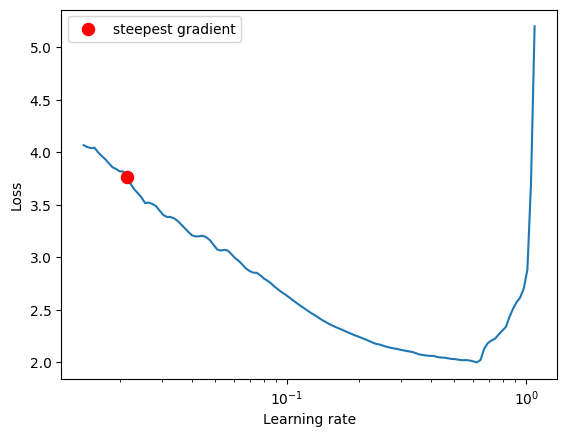

0.021461411978584043


In [84]:
# Use LR Finder to find the best starting learning rate
# https://github.com/davidtvs/pytorch-lr-finder
# https://github.com/davidtvs/pytorch-lr-finder#notes
# https://github.com/davidtvs/pytorch-lr-finder/blob/master/torch_lr_finder/lr_finder.py

# Create LR finder object
lr_finder = LRFinder(model, optimizer, criterion)
lr_finder.range_test(train_loader=train_loader, end_lr=10, num_iter=200, start_lr=1e-2)
# https://github.com/davidtvs/pytorch-lr-finder/issues/88
plot, suggested_lr = lr_finder.plot(suggest_lr=True)
lr_finder.reset()
plot.figure.savefig("LRFinder - Suggested Max LR.png")
print(suggested_lr)

In [85]:
print(f"Suggested Max LR: {suggested_lr}")

NUM_EPOCHS  = 24

# Learning rate scheduler based on OneCycleLR
# https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html
scheduler = OneCycleLR(
    optimizer,
    max_lr=suggested_lr,
    steps_per_epoch=len(train_loader),
    epochs=NUM_EPOCHS,
    pct_start=5 / NUM_EPOCHS,
    div_factor=5,
    three_phase=False,
    final_div_factor=20,
    verbose=False,
)

Suggested Max LR: 0.021461411978584043


In [86]:
for epoch in range(NUM_EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=1.705603837966919 Batch_id=97 Accuracy=22.64: 100%|██████████| 98/98 [00:22<00:00,  4.37it/s]



Test set: Average loss: 1.7308, Accuracy: 3857/10000 (38.57%)

EPOCH: 1


Loss=1.5495904684066772 Batch_id=97 Accuracy=40.52: 100%|██████████| 98/98 [00:20<00:00,  4.68it/s]



Test set: Average loss: 1.3939, Accuracy: 4917/10000 (49.17%)

EPOCH: 2


Loss=1.2381701469421387 Batch_id=97 Accuracy=51.79: 100%|██████████| 98/98 [00:20<00:00,  4.73it/s]



Test set: Average loss: 1.0806, Accuracy: 6080/10000 (60.80%)

EPOCH: 3


Loss=1.0628058910369873 Batch_id=97 Accuracy=60.28: 100%|██████████| 98/98 [00:21<00:00,  4.59it/s]



Test set: Average loss: 1.0220, Accuracy: 6442/10000 (64.42%)

EPOCH: 4


Loss=0.8565171360969543 Batch_id=97 Accuracy=65.04: 100%|██████████| 98/98 [00:21<00:00,  4.64it/s]



Test set: Average loss: 0.8421, Accuracy: 7036/10000 (70.36%)

EPOCH: 5


Loss=0.822067379951477 Batch_id=97 Accuracy=70.12: 100%|██████████| 98/98 [00:21<00:00,  4.64it/s]



Test set: Average loss: 0.7311, Accuracy: 7439/10000 (74.39%)

EPOCH: 6


Loss=0.7747349739074707 Batch_id=97 Accuracy=72.83: 100%|██████████| 98/98 [00:21<00:00,  4.64it/s]



Test set: Average loss: 0.6397, Accuracy: 7750/10000 (77.50%)

EPOCH: 7


Loss=0.6005505919456482 Batch_id=97 Accuracy=75.41: 100%|██████████| 98/98 [00:21<00:00,  4.66it/s]



Test set: Average loss: 0.5657, Accuracy: 8063/10000 (80.63%)

EPOCH: 8


Loss=0.5952730178833008 Batch_id=97 Accuracy=76.76: 100%|██████████| 98/98 [00:20<00:00,  4.71it/s]



Test set: Average loss: 0.5822, Accuracy: 8023/10000 (80.23%)

EPOCH: 9


Loss=0.6885240077972412 Batch_id=97 Accuracy=78.07: 100%|██████████| 98/98 [00:20<00:00,  4.70it/s]



Test set: Average loss: 0.4929, Accuracy: 8348/10000 (83.48%)

EPOCH: 10


Loss=0.6401772499084473 Batch_id=97 Accuracy=79.34: 100%|██████████| 98/98 [00:21<00:00,  4.56it/s]



Test set: Average loss: 0.5021, Accuracy: 8314/10000 (83.14%)

EPOCH: 11


Loss=0.5298858880996704 Batch_id=97 Accuracy=80.50: 100%|██████████| 98/98 [00:21<00:00,  4.64it/s]



Test set: Average loss: 0.4484, Accuracy: 8531/10000 (85.31%)

EPOCH: 12


Loss=0.4987903833389282 Batch_id=97 Accuracy=81.65: 100%|██████████| 98/98 [00:21<00:00,  4.63it/s]



Test set: Average loss: 0.4670, Accuracy: 8432/10000 (84.32%)

EPOCH: 13


Loss=0.5325143933296204 Batch_id=97 Accuracy=82.77: 100%|██████████| 98/98 [00:23<00:00,  4.17it/s]



Test set: Average loss: 0.4184, Accuracy: 8549/10000 (85.49%)

EPOCH: 14


Loss=0.5367814302444458 Batch_id=97 Accuracy=83.46: 100%|██████████| 98/98 [00:20<00:00,  4.69it/s]



Test set: Average loss: 0.3797, Accuracy: 8698/10000 (86.98%)

EPOCH: 15


Loss=0.46645042300224304 Batch_id=97 Accuracy=84.17: 100%|██████████| 98/98 [00:20<00:00,  4.69it/s]



Test set: Average loss: 0.4146, Accuracy: 8624/10000 (86.24%)

EPOCH: 16


Loss=0.34797796607017517 Batch_id=97 Accuracy=84.24: 100%|██████████| 98/98 [00:21<00:00,  4.67it/s]



Test set: Average loss: 0.3830, Accuracy: 8731/10000 (87.31%)

EPOCH: 17


Loss=0.4591755270957947 Batch_id=97 Accuracy=85.03: 100%|██████████| 98/98 [00:21<00:00,  4.53it/s]



Test set: Average loss: 0.3613, Accuracy: 8787/10000 (87.87%)

EPOCH: 18


Loss=0.4316156506538391 Batch_id=97 Accuracy=85.69: 100%|██████████| 98/98 [00:21<00:00,  4.55it/s]



Test set: Average loss: 0.3547, Accuracy: 8835/10000 (88.35%)

EPOCH: 19


Loss=0.34021878242492676 Batch_id=97 Accuracy=86.32: 100%|██████████| 98/98 [00:21<00:00,  4.62it/s]



Test set: Average loss: 0.3764, Accuracy: 8777/10000 (87.77%)

EPOCH: 20


Loss=0.4083506762981415 Batch_id=97 Accuracy=87.05: 100%|██████████| 98/98 [00:21<00:00,  4.66it/s]



Test set: Average loss: 0.3844, Accuracy: 8747/10000 (87.47%)

EPOCH: 21


Loss=0.31447863578796387 Batch_id=97 Accuracy=87.78: 100%|██████████| 98/98 [00:20<00:00,  4.68it/s]



Test set: Average loss: 0.3444, Accuracy: 8881/10000 (88.81%)

EPOCH: 22


Loss=0.43586841225624084 Batch_id=97 Accuracy=87.30: 100%|██████████| 98/98 [00:21<00:00,  4.59it/s]



Test set: Average loss: 0.3677, Accuracy: 8825/10000 (88.25%)

EPOCH: 23


Loss=0.32093825936317444 Batch_id=97 Accuracy=88.57: 100%|██████████| 98/98 [00:21<00:00,  4.54it/s]



Test set: Average loss: 0.3405, Accuracy: 8933/10000 (89.33%)

